In [1]:
#MODIFIED large_scale_unlearning.ipynb from https://github.com/meghdadk/SCRUB/blob/main/large_scale_unlearning.ipynb

import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import numpy as np
import random 
import copy
import torch
import torch.nn as nn
from typing import List
import itertools
#from tqdm.autonotebook import tqdm
from tqdm import tqdm

import pickle


import models
import datasets

In [2]:
#from models import *
#import models
#from logger import *

from SCRUB.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from SCRUB.distiller_zoo.KD import DistillKL

from SCRUB.helper.loops import train_distill, train_vanilla, validate
from SCRUB.helper.pretrain import init
from SCRUB.helper.util import AverageMeter

In [3]:
checkpoint_name = 'lacuna100binary128_resnetsmooth_1_0_forget_None_lr_0_01_bs_512_ls_ce_seed_1_scheduler_1'

In [4]:
with open(f'logs/{checkpoint_name}.pkl', 'rb') as f:
    train_dict = pickle.load(f)


In [5]:
# eta = 0.01
# n = 32000

# batch_size = train_dict['batch_size']
# Nepochs = train_dict['selected epoch']+1
# Nbatches = math.ceil(n/batch_size)

# T = Nepochs * Nbatches

seed = 1

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")




checkpoints= [0, 20, 50, 100, 150, 200, 250]
checkpoints = [0, 20, 40, 50, 70, 120, 150, 170, 200,220, 250]
#checkpointarray=( 40 70 120 170 220 )

In [7]:
dataroot = 'data/lacuna100binary128/'
loaders = datasets.get_loaders_large('lacuna100binary128', num_ids_forget = 2, batch_size=512, seed=seed, root=dataroot, test=True)

Forgetting these IDs: [5249, 3520]
Number of training samples: 31353
Number of validation samples: 7847
Number of test samples: 10000
Number of ood samples: 10000
Number of train forget samples: 647
Number of test forget samples: 200
Number of test retain samples: 9800


In [8]:
train_loader = loaders['train_loader']
train_forget_loader = loaders['train_forget_loader']
forget_loader = loaders['forget_loader']

test_loader = loaders['test_loader']

ood_loader = loaders['ood_loader']

test_forget_loader = loaders['test_forget_loader']
test_retain_loader = loaders['test_retain_loader']

In [9]:
model = models.get_model('resnetsmooth', num_classes=2, filters_percentage=1)
model.to(device)

og_name = checkpoint_name + '_selected'


In [10]:
retain_loader = train_forget_loader
valid_loader = loaders['valid_loader'] 

## Load checkpoints

In [11]:
import copy
model0 = copy.deepcopy(model)

m_name = og_name #f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
#m0_name = full_retrain_name#f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load('checkpoints/' + m_name + '.pt', weights_only='True'))
#model0.load_state_dict(torch.load('checkpoints/' + m0_name + '.pt', weights_only='True'))


model.cuda()
#model0.cuda()


for p in model.parameters(): #what is the point of this
    p.data0 = p.data.clone()
#for p in model0.parameters():
#    p.data0 = p.data.clone()

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

# SCRUB Forgetting

In [12]:
from argparse import Namespace

# start with an empty Namespace
args = Namespace()

In [13]:
#large-scale hyperparameters
args.optim = 'sgd'
args.gamma = 0.99
args.alpha = 0.001
args.beta = 0
args.smoothing = 0.0
args.msteps = 2
args.clip = 0.2
args.sstart = 10
args.kd_T = 4
args.distill = 'kd'

args.sgda_batch_size = 128
args.del_batch_size = 32
args.sgda_epochs = 3
args.sgda_epochs = 10
args.sgda_learning_rate = 0.0005
args.lr_decay_epochs = [3,5,9]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 5e-4
args.sgda_momentum = 0.9

In [14]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [15]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = torch.optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = torch.optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = torch.optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [16]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True

In [17]:
acc_rs = []
acc_fs = []
acc_ts = []
acc_vs = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> SCRUB unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, None, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, None, criterion_list, optimizer, args, "minimize")

    
    print ("maximize loss: {:.10f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
acc_v, acc5_v, loss_v = validate(valid_loader, model_s, criterion_cls, args, True)
acc_rs.append(100-acc_r.item())
acc_fs.append(100-acc_f.item())
acc_vs.append(100-acc_v.item())

==> SCRUB unlearning ...


/nfs/home/smg5501/.conda/envs/myenv/lib/python3.9/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 98.145 
maximize loss: -0.0000000251	 minimize loss: 0.05	 train_acc: 98.1452865600586
==> SCRUB unlearning ...
 * Acc@1 99.073 
maximize loss: -0.0033259138	 minimize loss: 0.04	 train_acc: 99.07263946533203
==> SCRUB unlearning ...
 * Acc@1 98.609 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 98.60896301269531
==> SCRUB unlearning ...
 * Acc@1 98.918 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 98.91808319091797
==> SCRUB unlearning ...
 * Acc@1 99.227 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 99.2271957397461
==> SCRUB unlearning ...
 * Acc@1 99.382 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 99.38175964355469
==> SCRUB unlearning ...
 * Acc@1 99.382 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 99.38175964355469
==> SCRUB unlearning ...
 * Acc@1 99.382 
maximize loss: 0.0000000000	 minimize loss: 0.04	 train_acc: 99.38175964355469
==> SCRUB unlearning ...
 * Acc@1 99.382 
maximize loss: 

In [18]:
 torch.save(model_s.state_dict(), f"other_baselines/SCRUB_{checkpoint_name}.pt") 

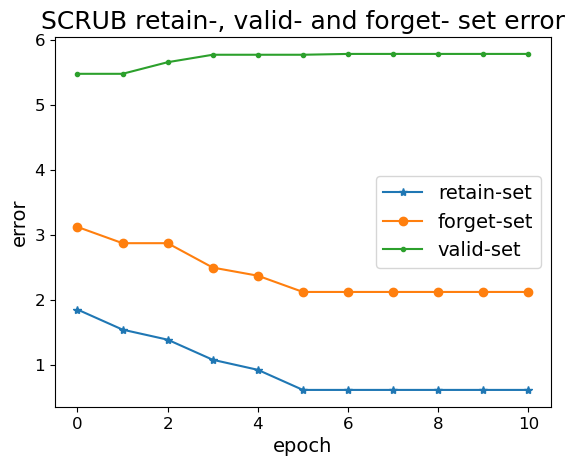

In [19]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('SCRUB retain-, valid- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

# Fisher

In [21]:
model.load_state_dict(torch.load('checkpoints/' + og_name + '.pt', weights_only='True'))

modelf = copy.deepcopy(model)
#modelf0 = copy.deepcopy(model0)

modelf.to(device)

for p in itertools.chain(modelf.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [22]:
def hessian(dataset, model, device):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target, _ in tqdm(train_loader):
        data, orig_target = data.to(device), orig_target.to(device)
        output = model(data)
        prob = torch.nn.functional.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [23]:
hessian(retain_loader.dataset, modelf, device)
#hessian(retain_loader.dataset, modelf0)

100%|██████████| 647/647 [00:32<00:00, 19.66it/s]


In [24]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6, num_classes=2):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    # if p.size(0) == num_classes and num_to_forget is None:
    #     mu[class_to_forget] = 0
    #     var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [25]:
alpha = 1e-8
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

# for i, p in enumerate(modelf0.parameters()):
#     mu, var = get_mean_var(p, False, alpha=alpha)
#     p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()


In [26]:
print(var)

tensor([3.7350e-06, 3.7350e-06], device='cuda:1')


In [27]:
 torch.save(modelf.state_dict(), f"other_baselines/Fisher_{checkpoint_name}.pt") 

# Fine Tune 

In [52]:

import time

from utils import *


from main import run_epoch_simple

def run_epoch_simple(model, data_loader, device, criterion=torch.nn.CrossEntropyLoss(), optimizer=None):
    model.train()

    with torch.set_grad_enabled(True):

        for batch_idx, (data, target, identity) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)

                
            output = model(data)
            loss = criterion(output, target) 

            optimizer.zero_grad() 
            loss.backward()

            optimizer.step()    


manual_seed(seed)



#get model
model.load_state_dict(torch.load('checkpoints/' + m_name + '.pt', weights_only='True'))
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, weight_decay=0)


criterion = torch.nn.CrossEntropyLoss().to(device)

train_time = 0


epochs = 10

for epoch in tqdm(range(epochs)):

    t1 = time.time()

    _ = run_epoch_simple(model, train_loader, device, criterion, optimizer)

    t2 = time.time()
    train_time += np.round(t2-t1,2)




torch.save(model.state_dict(), f"other_baselines/Finetune_{checkpoint_name}.pt") 





100%|██████████| 10/10 [09:23<00:00, 56.37s/it]
